In [1]:
import numpy as np
import os
import cv2
import h5py
import struct
import vtk
import vtk.util
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from volume_extraction import *
from utilities import *
from VTKFunctions import *
from GradDesOrient import *
from scipy.ndimage import affine_transform, rotate, zoom, shift
#from joblib import Parallel, delayed

from ipywidgets import FloatProgress
from IPython.display import display

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignor

In [146]:
def return_interface(data, mask):
    """ Returns mean distance between surface and calcified cartilage interface.
    """
    # Threshold data
    surfmask, val = otsuThreshold(data)
    surf = np.argmax(surfmask * 1.0, 2)
    _, val = otsuThreshold(data)
    cci = np.argmax(mask, 2)
    cci = medfilt(cci, kernel_size=5)
    
    return np.mean(cci - surf)

def GetInterface(data, size, choice='surface', mask=None):
    """Give string input to interface variable as 'surface' or 'bci'.
Input data should be a thresholded, cropped volume of the sample"""
    p = FloatProgress(min=0, max=size[0], description='Get interface:')
    display(p)
    dims = np.shape(data)
    if (dims[0] != size[0]) or (dims[1] != size[0]):
        raise Exception('Sample and voi size are incompatible!')
    surfvoi = np.zeros((dims[0], dims[1], size[1]))
    deepvoi = np.zeros((dims[0], dims[1], size[3]))
    ccvoi = np.zeros((dims[0], dims[1], size[1]))
        
    # Threshold data
    if choice == 'surface':
        mask, val = otsuThreshold(data)
        print('Global threshold: {0} (Otsu)'.format(val))
        interface = np.argmax(mask * 1.0, 2)
    elif choice == 'bci':
        _, val = otsuThreshold(data)
        interface = np.argmax(mask, 2)
        interface = medfilt(interface, kernel_size=5)
    else:
        raise Exception('Select an interface to be extracted!')
    plt.imshow(np.sum(mask, 2))  # display sum of mask
    plt.show()

    # Get coordinates and extract voi
    deptharray = []
    for x in range(size[0]):
        for y in range(size[0]):
            if choice == 'surface':
                depth = np.uint(interface[x, y])
                surfvoi[x, y, :] = data[x, y, depth:depth + size[1]]
            elif choice == 'bci':
                # Check for sample edges
                if interface[x, y] < size[3]:  # surface edge
                    depth = np.uint(size[3])
                elif dims[2] - interface[x, y] < size[1]:  # bottom edge
                    depth = np.uint(dims[2] - size[1])
                else:  # add only offset
                    depth = np.uint(interface[x, y] - size[2])

                # check for void (deep voi)
                void = False
                for z in range(size[3]):
                    if data[x, y, depth - z] < val / 2:
                        void = True
                        
                if void:
                    # In case of void, don't use offset
                    if depth < np.uint(dims[2] - size[1]):
                        ccvoi[x, y, :] = data[x, y, depth + size[2]:depth + size[4] + size[2]]
                    else:
                        ccvoi[x, y, :] = data[x, y, depth:depth + size[4]]
                    
                    if depth - size[3] > size[2]:
                        zz = size[2] # starting index
                    else:
                        zz = 0
                    while data[x, y, depth - zz] < val and depth - zz > dims[2] / 3:
                        zz += 1
                    depth = depth - zz
                else: 
                    # If void not found, calculate ccvoi normally
                    ccvoi[x, y, :] = data[x, y, depth:depth + size[4]]
                    
                deptharray.append(depth)
                deepvoi[x, y, :] = data[x, y, depth - size[3]:depth]
            else:
                raise Exception('Select an interface to be extracted!')
        p.value += 1
    if choice == 'surface':
        return surfvoi, interface, val
    elif choice == 'bci':
        print('Mean interface = {0}, mean depth = {1}'.format(np.mean(interface), np.mean(np.array(deptharray))))
        return deepvoi, ccvoi, interface

In [ ]:
path = r"Z:\3DHistoData\Test data\Void"
maskpath = r"Z:\3DHistoData\Test data\Void\Mask"
data, bounds = Load(path)
PrintOrthogonal(data)
mask, bounds = Load(maskpath)
PrintOrthogonal(mask)
data = data[24:-24, 24:-24, :]
mask = mask[24:-24, 24:-24, :]

In [153]:
size = [448, 25, 10, 150, 50]# width, surf depth, offset, deep depth, cc depth
# Crop
sizetemp = size[:]
sizetemp[0] = 400

# Calculate cartilage depth
dist = return_interface(data, mask)
sizetemp[3] = (0.6 * dist).astype('int')

print(dist)
print(data.shape)

1245.0563875
(400, 400, 1875)


FloatProgress(value=0.0, description='Get interface:', max=400.0)

Global threshold: 57.72625 (Otsu)


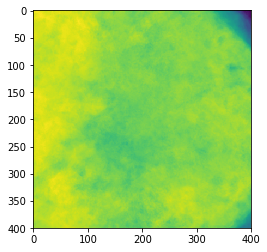

FloatProgress(value=0.0, description='Get interface:', max=400.0)

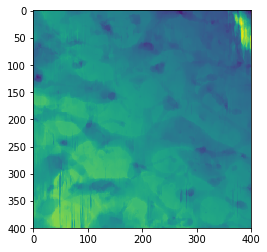

ValueError: could not broadcast input array from shape (50) into shape (25)

In [154]:
surfvoi, interface, otsu_thresh = GetInterface(data, sizetemp, 'surface', None)
deepvoi, ccvoi, interface = GetInterface(data, sizetemp, 'bci', (mask > 0.7))
PrintOrthogonal(surfvoi)
PrintOrthogonal(deepvoi)
PrintOrthogonal(ccvoi)

Selected files
14_R3L_2_PTA_48h_Rec
14_R6LT_2_PTA_48h_Rec
15_L6TL_2_PTA_48h_Rec
20_R2M_2_PTA_48h_Rec
21_L6LT_1_PTA_48h_Rec
22_L3L_2_PTA_48h_Rec
22_L6TL_2_PTA_48h_Rec
25_L3L_1_PTA_48h_Rec
26_L3L_2_PTA_48h_Rec
27R3M_2_PTA_72h_Rec
28L3L_4_PTA_48h_Rec
28_L6MT_2_PTA_48h_Rec
29_R2M_2_PTA_48h_Rec
31_R6LT_2_PTA_48h_Rec
32_L3L_2_PTA_48h_Rec
32_L6MT_2_PTA_48h_Rec
O17_R3L_2_PTA_48h_Rec
O17_R6L_2_PTA_48h_Rec
O19_L6L_8_PTA_48h_Rec
14_R3L_2_PTA_48h_Rec
Sample name: 14_R3L_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1264.0)

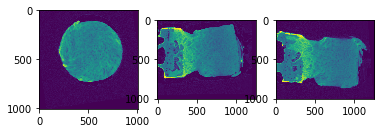

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_input_render.png
2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

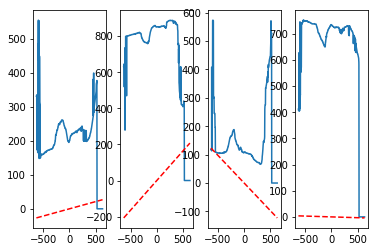

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


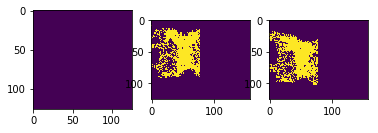

BBox angles: [ 10.29175949], [-5.67563581]
PCA angles: [[-6.87097577]], [[-0.57414512]]
Gradient descent angles: -2.3125, -3.1875
Average angles selected.
Average angles: [[ 0.36942791]], [[-3.14576031]]


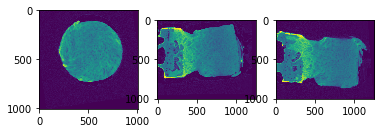

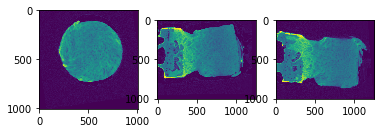

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_orient_render.png
3. Crop and flip center volume:


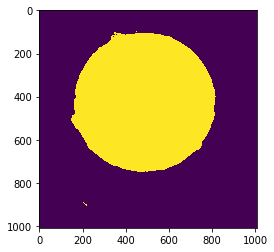

FloatProgress(value=0.0, description='Get center:', max=1008.0)

Sum image along z-axis


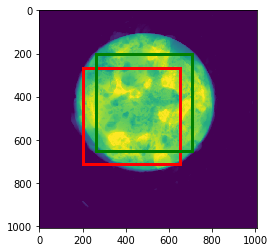

Center moment (green): x = 485, y = 426
Center of mass (red): x = 428.0, y = 490.0


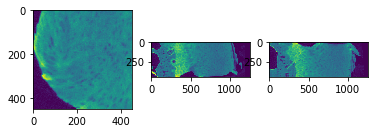

(448, 448, 1255)
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_orient_cropped_render.png


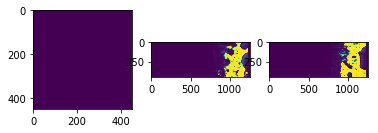

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=384.0)

Global threshold: 62.37109375 (Otsu)


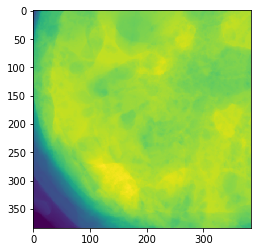

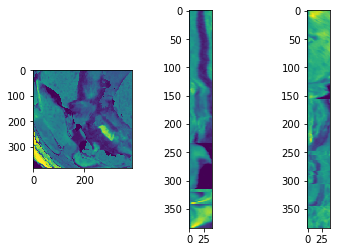

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_surface_render.png


FloatProgress(value=0.0, description='Get interface:', max=384.0)

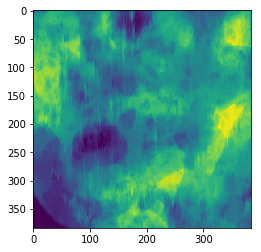

Mean interface = 948.8106892903646, mean depth = 933.5948215060764


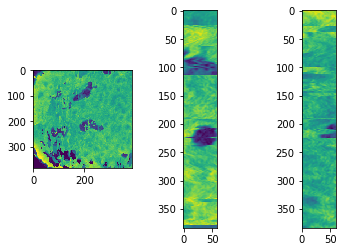

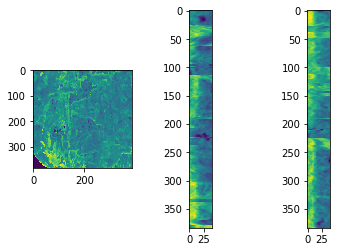

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_deep_render.png
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R3L_2_PTA_48h_Rec_cc_render.png
5. Save mean and std images


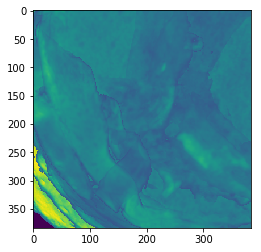

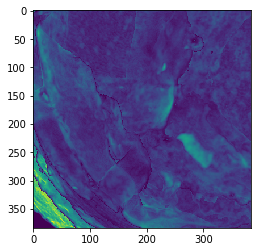

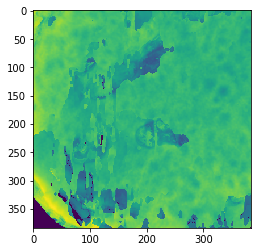

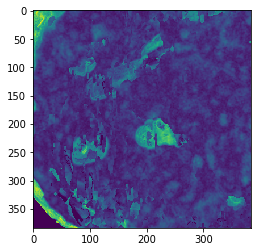

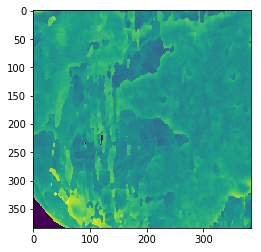

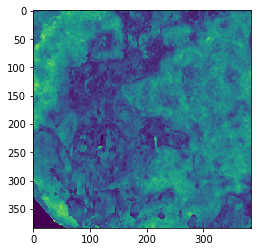

14_R6LT_2_PTA_48h_Rec
Sample name: 14_R6LT_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1271.0)

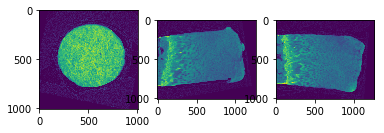

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_input_render.png
2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

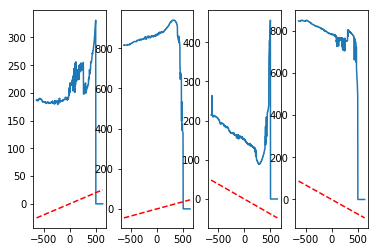

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


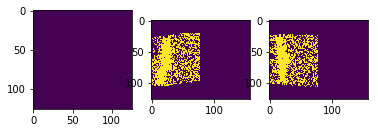

BBox angles: [ 3.16861725], [-6.0843401]
PCA angles: [[ 9.18918613]], [[ 10.38349568]]
Gradient descent angles: -1.0625, 0.5625
Average angles selected.
Average angles: [[ 3.76510113]], [[ 1.62055186]]


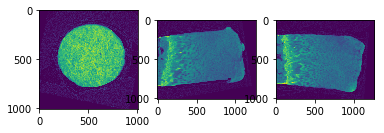

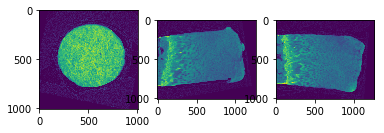

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_orient_render.png
3. Crop and flip center volume:


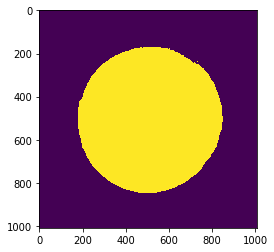

FloatProgress(value=0.0, description='Get center:', max=1008.0)

Sum image along z-axis


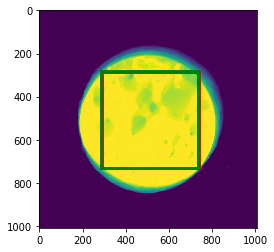

Center moment (green): x = 511, y = 506
Center of mass (red): x = 514.0, y = 507.0


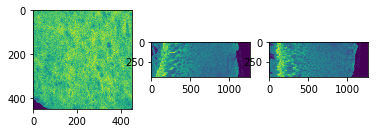

(448, 448, 1263)
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_orient_cropped_render.png


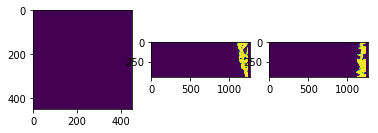

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=384.0)

Global threshold: 52.07682291666667 (Otsu)


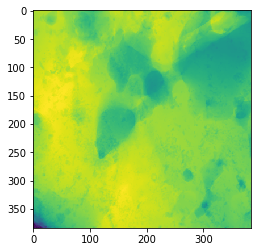

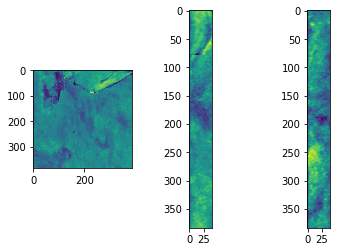

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_surface_render.png


FloatProgress(value=0.0, description='Get interface:', max=384.0)

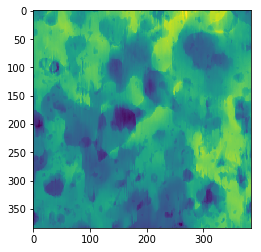

Mean interface = 1140.214579264323, mean depth = 1130.2200724283855


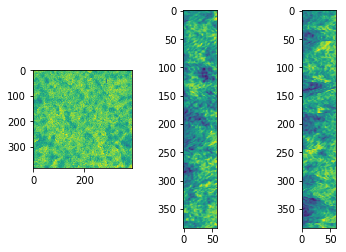

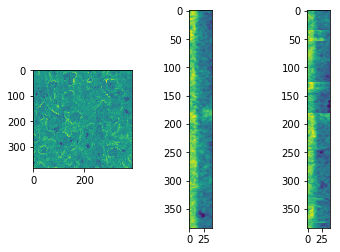

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_deep_render.png
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\14_R6LT_2_PTA_48h_Rec_cc_render.png
5. Save mean and std images


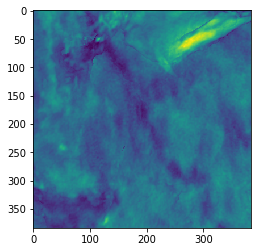

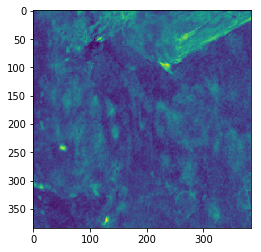

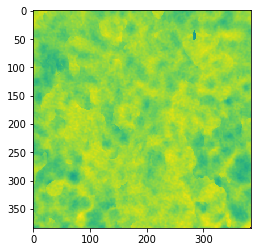

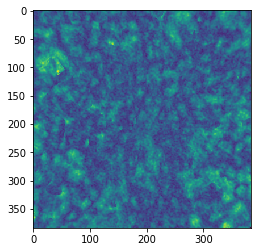

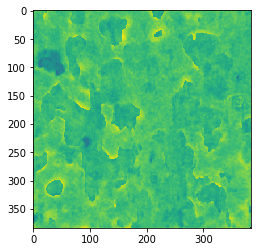

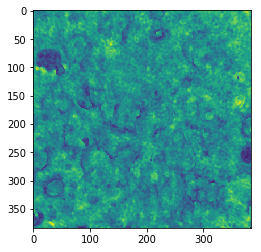

15_L6TL_2_PTA_48h_Rec
Sample name: 15_L6TL_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1266.0)

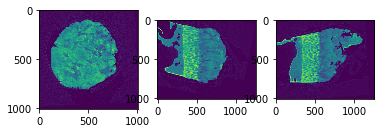

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_input_render.png
2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

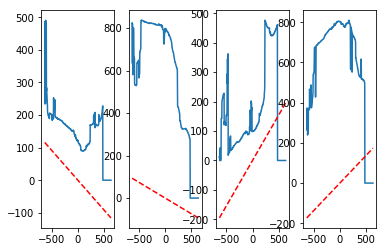

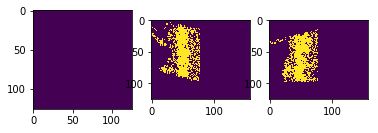

BBox angles: [-9.38181496], [ 16.21751022]
PCA angles: [[ 32.62925901]], [[-37.57015261]]
Gradient descent angles: -4.5625, 5.6875
Average angles selected.
Average angles: [-6.97215748], [ 10.95250511]


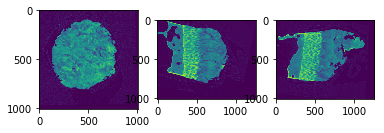

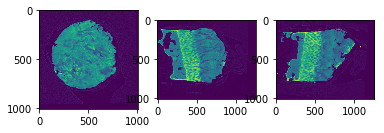

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_orient_render.png
3. Crop and flip center volume:


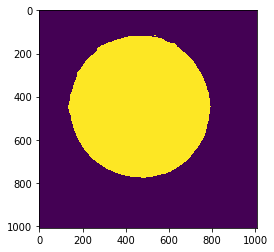

FloatProgress(value=0.0, description='Get center:', max=1008.0)

Sum image along z-axis


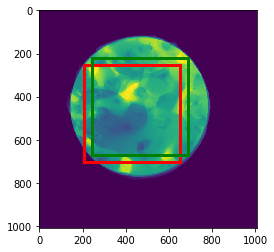

Center moment (green): x = 466, y = 446
Center of mass (red): x = 429.0, y = 477.0


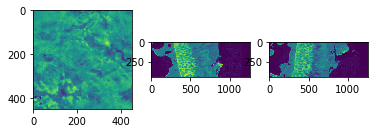

(448, 448, 1258)
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_orient_cropped_render.png


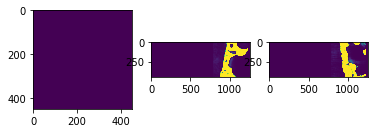

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=384.0)

Global threshold: 61.055989583333336 (Otsu)


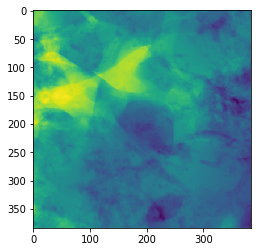

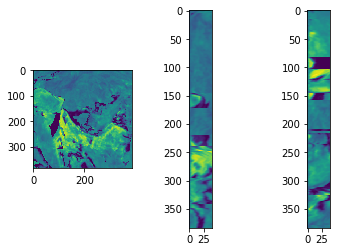

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_surface_render.png


FloatProgress(value=0.0, description='Get interface:', max=384.0)

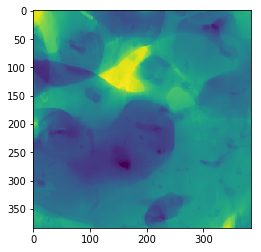

Mean interface = 928.6090291341146, mean depth = 918.613525390625


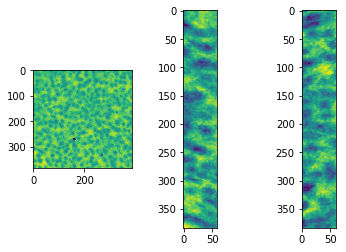

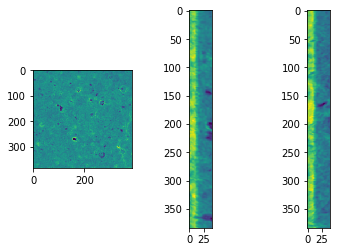

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_deep_render.png
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\15_L6TL_2_PTA_48h_Rec_cc_render.png
5. Save mean and std images


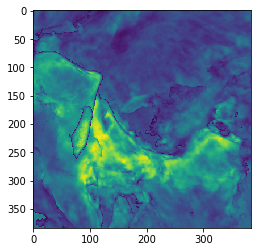

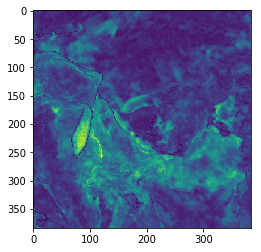

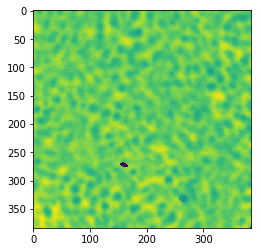

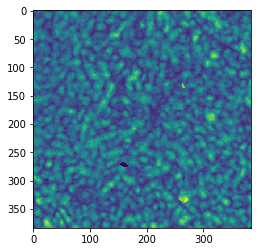

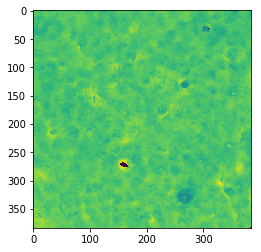

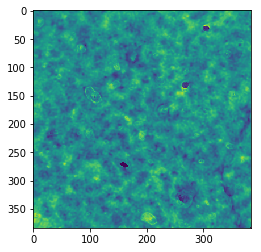

20_R2M_2_PTA_48h_Rec
Sample name: 20_R2M_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1188.0)

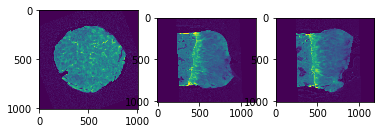

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_input_render.png
2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

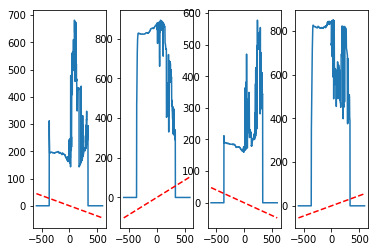

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


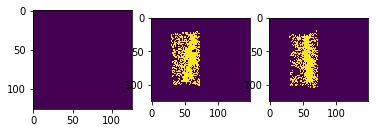

BBox angles: [ 2.77872801], [ 0.35126567]
PCA angles: [[ 86.37387486]], [[-84.35463069]]
Gradient descent angles: 4.6875, 5.6875
Average angles selected.
Average angles: [ 3.733114], [ 3.01938295]


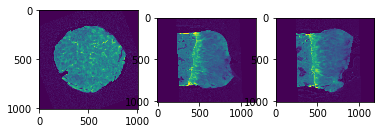

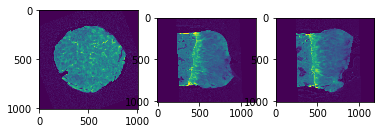

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_orient_render.png
3. Crop and flip center volume:


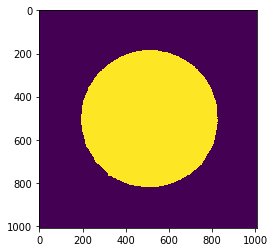

FloatProgress(value=0.0, description='Get center:', max=1008.0)

Sum image along z-axis


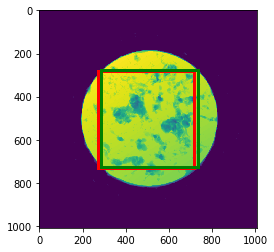

Center moment (green): x = 510, y = 502
Center of mass (red): x = 494.0, y = 504.0


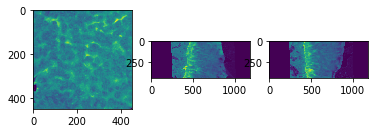

(448, 448, 1180)
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_orient_cropped_render.png


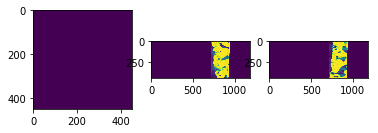

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=384.0)

Global threshold: 49.08203125 (Otsu)


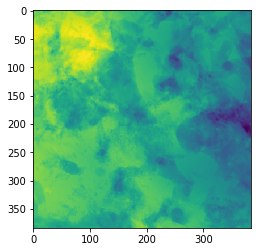

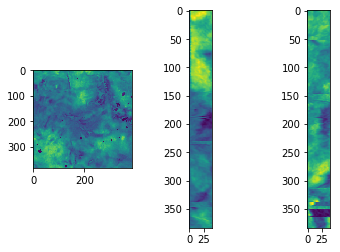

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_surface_render.png


FloatProgress(value=0.0, description='Get interface:', max=384.0)

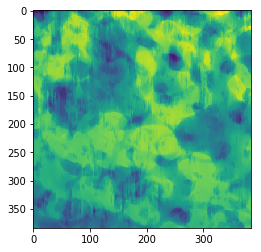

Mean interface = 756.3017103407118, mean depth = 746.2016059027778


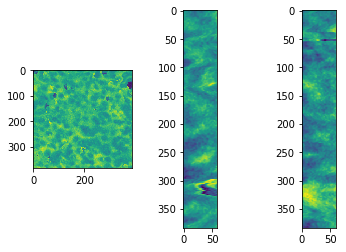

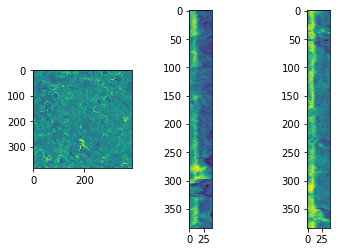

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_deep_render.png
Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\20_R2M_2_PTA_48h_Rec_cc_render.png
5. Save mean and std images


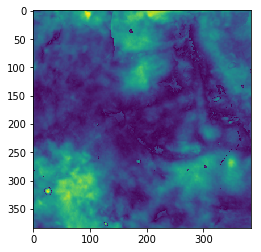

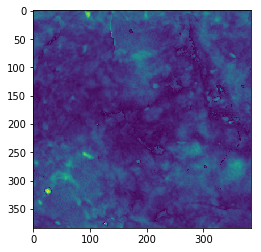

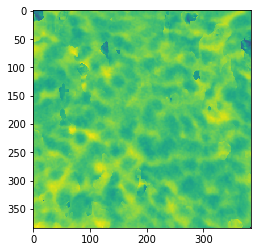

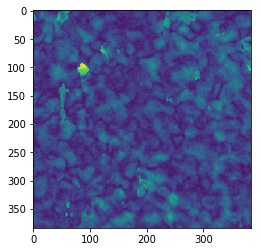

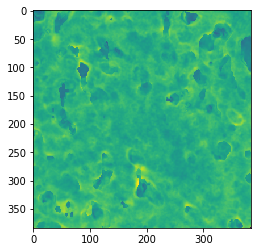

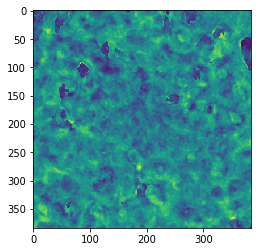

21_L6LT_1_PTA_48h_Rec
Z:\3DHistoData\rekisteroidyt\21_L6LT_1_PTA_48h_Rec\21_L6LT_1_PTA_48h_Rec\Registration
Sample name: 21_L6LT_1_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1158.0)

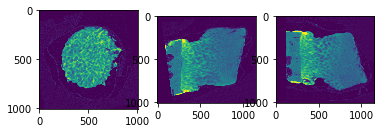

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\21_L6LT_1_PTA_48h_Rec_input_render.png
2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

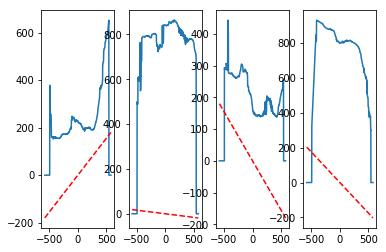

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


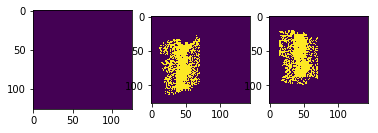

BBox angles: [ 7.71864891], [-18.28358078]
PCA angles: [[ 12.61340127]], [[ 23.58269398]]
Gradient descent angles: -0.5625, -0.5625
Average angles selected.
Average angles: [[ 6.58985006]], [-9.42304039]


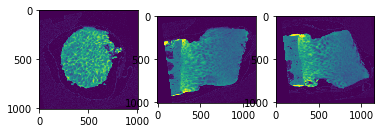

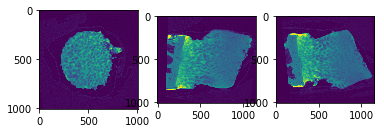

Saved to: Z:\3DHistoData\SurfaceImages - revised\Images\21_L6LT_1_PTA_48h_Rec_orient_render.png
3. Crop and flip center volume:


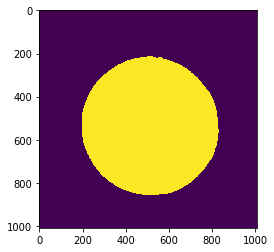

FloatProgress(value=0.0, description='Get center:', max=1008.0)

KeyboardInterrupt: 

In [3]:
### Parameters
impath = r"Z:\3DHistoData\rekisteroidyt"
modelpath = [r"Z:\Tuomas\Models\UNET_384x448.model", r"Z:\Tuomas\Models\UNET_448x448.model", r"Z:\Tuomas\Models\UNET_512x448.model"]
savepath = r"Z:\3DHistoData\SurfaceImages - revised"
sample = '15_L6TL_2'
threshold = 70
size = [448, 40, 10, 60] # width, depth, offset, deep depth

CalculateBatch(impath, savepath, size, threshold, False, modelpath)

### Pipeline debugging

Sample name: 15_L6TL_2
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=625.0)

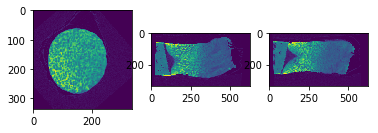

625


KeyboardInterrupt: 

In [3]:
# Parameters
#path = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_PTA_48h_Rec\24_R6LT_2_PTA_48h_Rec\Registration"
#mask = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_CA4+_Rec\24_R6LT_2_CA4+_Rec\Suoristettu\Registration\bone_mask"
path = r"Z:\3DHistoData\Test data\24_R6LT_2_binned"
#maskpath = r"Z:\3DHistoData\Test data\21_L3L_binned\bonemask"
maskpath = None
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
modelpath = None
threshold = 80
size = [100, 10, 5] # width, depth, offset

print('Sample name: ' + sample); print('1. Load sample')
data, bounds = Load(path)
PrintOrthogonal(data)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)
if maskpath is not None and modelpath is None:
    print(maskpath)
    mask, _ = Load(maskpath)
    PrintOrthogonal(mask)
    
print(np.shape(data)[2])
Save(r'Z:\3DHistoData\Test data\Void', sample, data)

In [ ]:
# Parameters
#path = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_PTA_48h_Rec\24_R6LT_2_PTA_48h_Rec\Registration"
#mask = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_CA4+_Rec\24_R6LT_2_CA4+_Rec\Suoristettu\Registration\bone_mask"
path = r"Z:\3DHistoData\Test data\24_R6LT_2_binned"
#maskpath = r"Z:\3DHistoData\Test data\21_L3L_binned\bonemask"
maskpath = None
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
modelpath = None
threshold = 80
size = [100, 10, 5] # width, depth, offset
Pipeline(path, sample, savepath, size, None, modelpath, True)

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

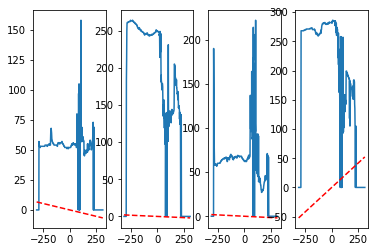

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


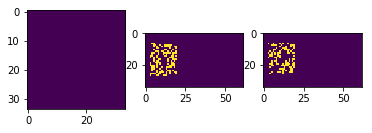

BBox angles: [-0.795161], [4.564634]
PCA angles: [[4.62088481]], [[2.49746329]]
Gradient descent angles: 0.0, 0.0
Gradient descent selected.


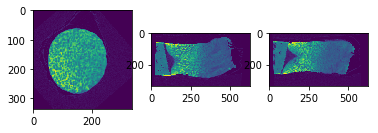

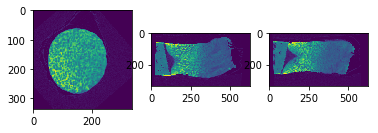

In [3]:
# Orient array
print('2. Orient sample')
ori, angles = Orient(data, bounds)
PrintOrthogonal(ori)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", ori)
if maskpath is not None and modelpath is None:
    mask = OrientMask(mask, angles)

3. Crop and flip center volume:


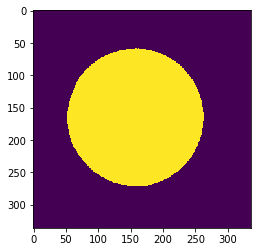

FloatProgress(value=0.0, description='Get center:', max=336.0)

Sum image along z-axis


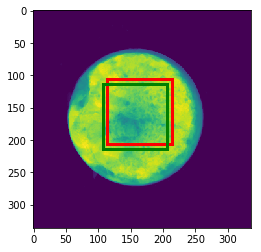

Center moment (green): x = 157, y = 164
Center of mass (red): x = 164.0, y = 156.0


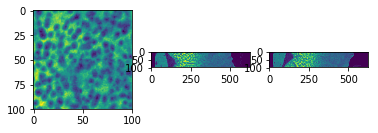

(100, 100, 625)


In [4]:
# Crop and flip volume
print('3. Crop and flip center volume:')
data, crop = CropCenter(ori, threshold, size[0]) # crop data
PrintOrthogonal(data); print(data.shape)
if maskpath is not None and modelpath is None:
    mask = mask[crop[0]:crop[1], crop[2]:crop[3], :] # crop mask
    data = np.flip(data, 2); mask = np.flip(mask, 2) # flip
if modelpath is not None:
    mask = CNTKSegmentation(data, modelpath) # generate mask from crop data
    data = np.flip(data, 2); mask = np.flip(mask, 2) # flip
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)

In [ ]:
Save()

In [6]:
path = r'Z:\3DHistoData\Test data\Void'
maskpath = r'Z:\3DHistoData\Test data\Void\Mask'

data, bounds = Load(path)
PrintOrthogonal(data)
mask, _ = Load(maskpath)
PrintOrthogonal(mask)

FloatProgress(value=0.0, description='Loading:', max=2083.0)

ValueError: axes don't match array

FloatProgress(value=0.0, description='Loading:', max=1876.0)

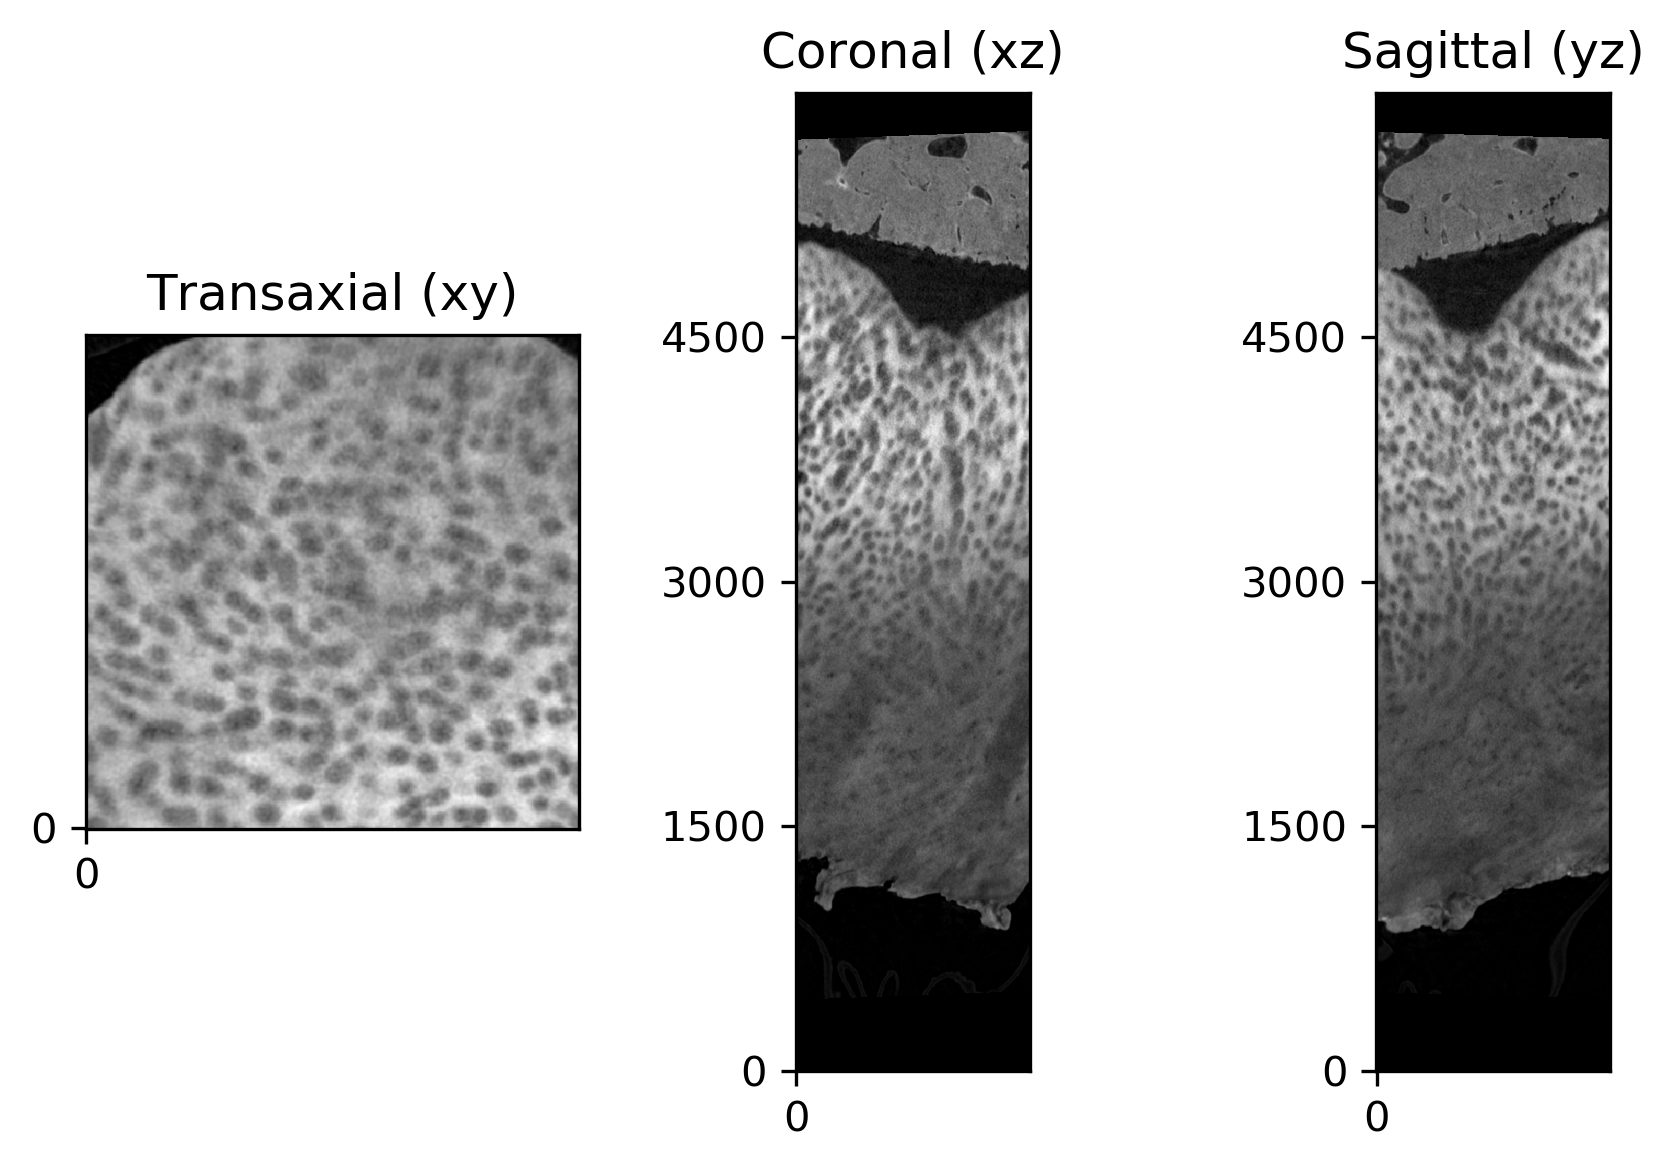

FloatProgress(value=0.0, description='Loading:', max=1875.0)

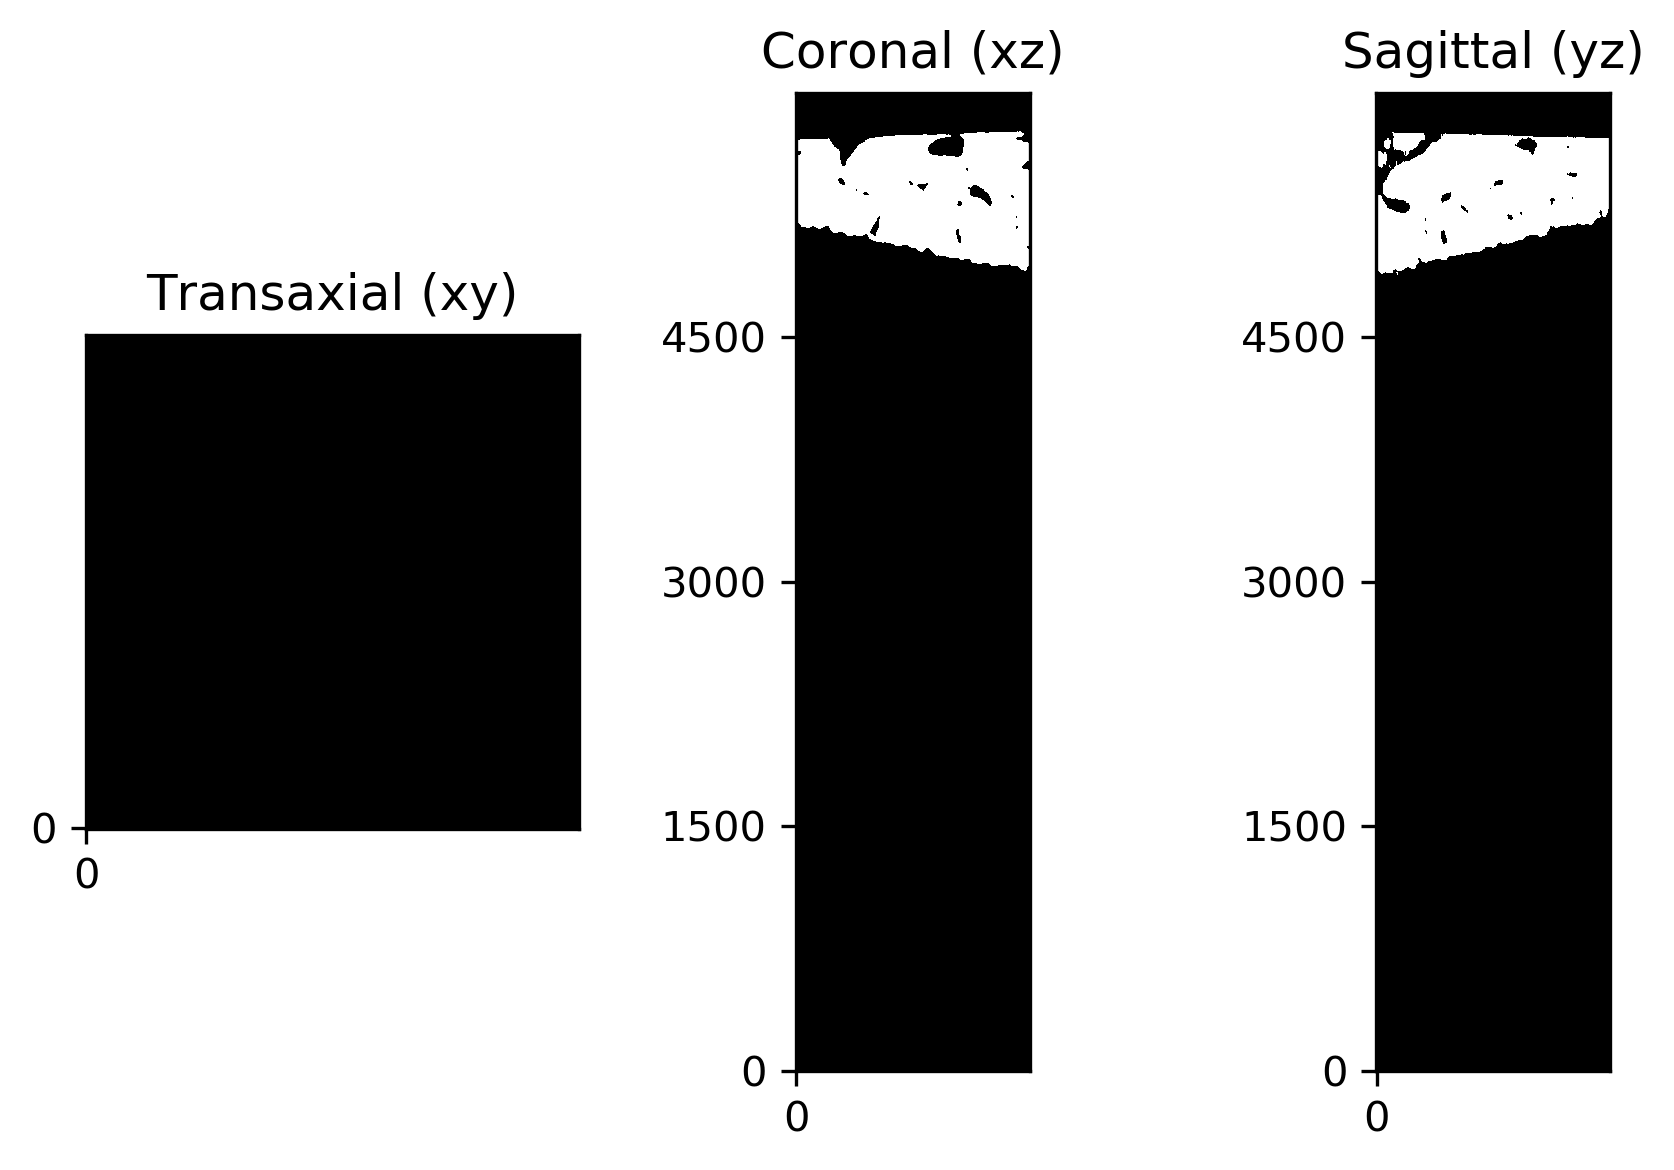

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=384.0)

Global threshold: 56.915364583333336 (Otsu)


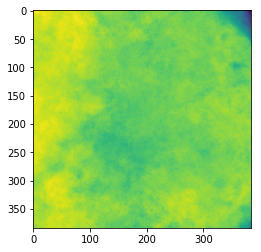

ValueError: too many values to unpack (expected 2)

In [4]:
path = r'Z:\3DHistoData\Test data\Void'
maskpath = r'Z:\3DHistoData\Test data\Void\Mask'

data, bounds = Load(path)
PrintOrthogonal(data)
mask, _ = Load(maskpath)
PrintOrthogonal(mask)
threshold = 80
size = [384, 40, 10, 60] # width, depth, offset
savepath = r"Z:\3DHistoData\Test data"
sample = 'test'

data = data[32:-32, 32:-32, :]
mask = mask[32:-32, 32:-32, :]

# Get VOIs
print('4. Get interface coordinates:')
surfvoi, interface = GetInterface(data, size, 'surface')
PrintOrthogonal(surfvoi)
deepvoi, ccvoi, interface = GetInterface(data, size, 'bci', (mask>0.7))
PrintOrthogonal(deepvoi); PrintOrthogonal(ccvoi)

RenderVolume(surfvoi, savepath + "\\Images\\" + sample + "_surface_render.png")
RenderVolume(deepvoi, savepath + "\\Images\\" + sample + "_deep_render.png")
RenderVolume(ccvoi, savepath + "\\Images\\" + sample + "_cc_render.png")
    
MeanStd(surfvoi, savepath, sample, deepvoi, ccvoi, False)

In [4]:
Save(r'Z:\3DHistoData\Test data\Surface', 'Surface', surfvoi)

5. Save mean and std images


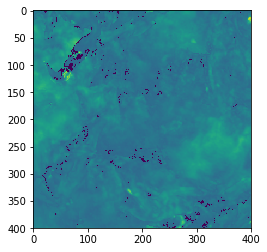

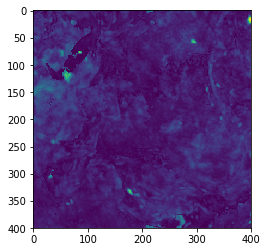

FileNotFoundError: [Errno 2] No such file or directory: '\\Surface\\_surface_mean.dat'

In [9]:
 # 5. Calculate mean and std
print('5. Save mean and std images')
if maskpath is not None or modelpath is not None:
    MeanStd(surfvoi, savepath, sample, deepvoi, ccvoi)
else:
    MeanStd(surfvoi, savepath, sample)

### Create test object

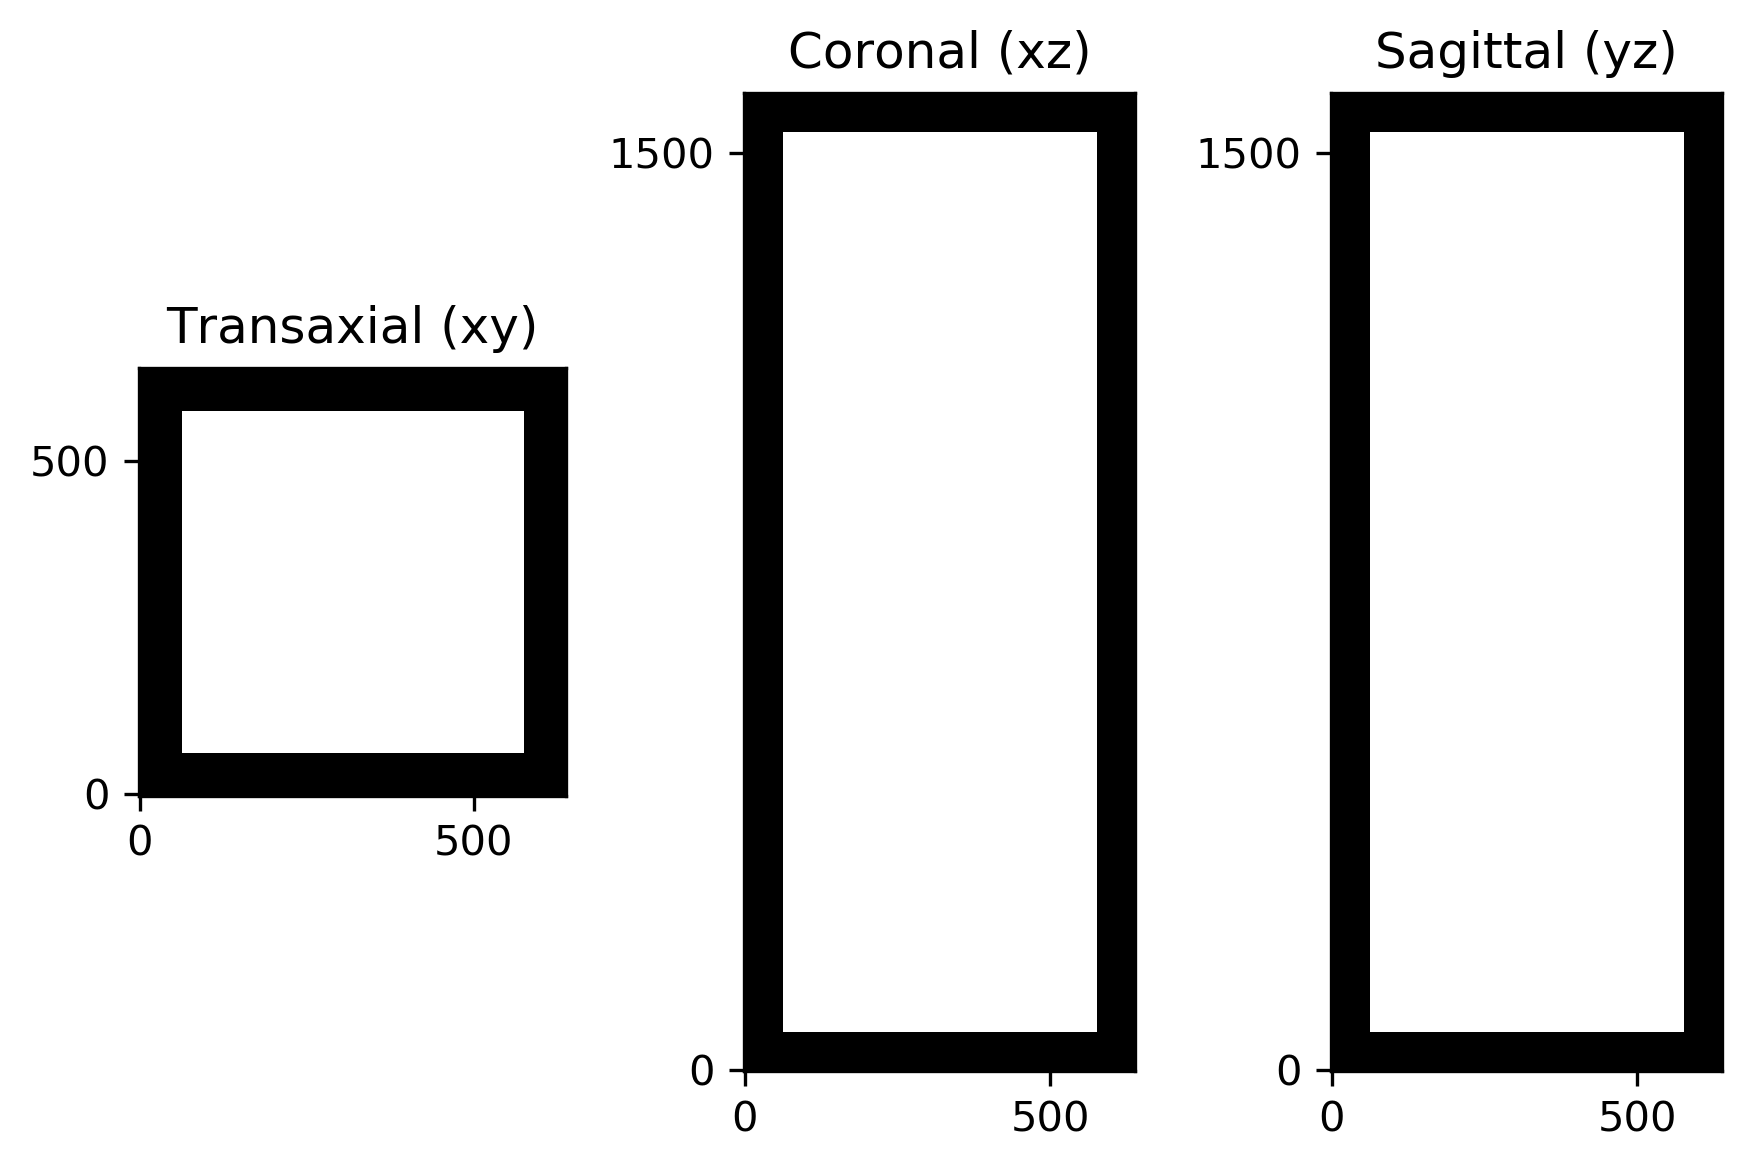

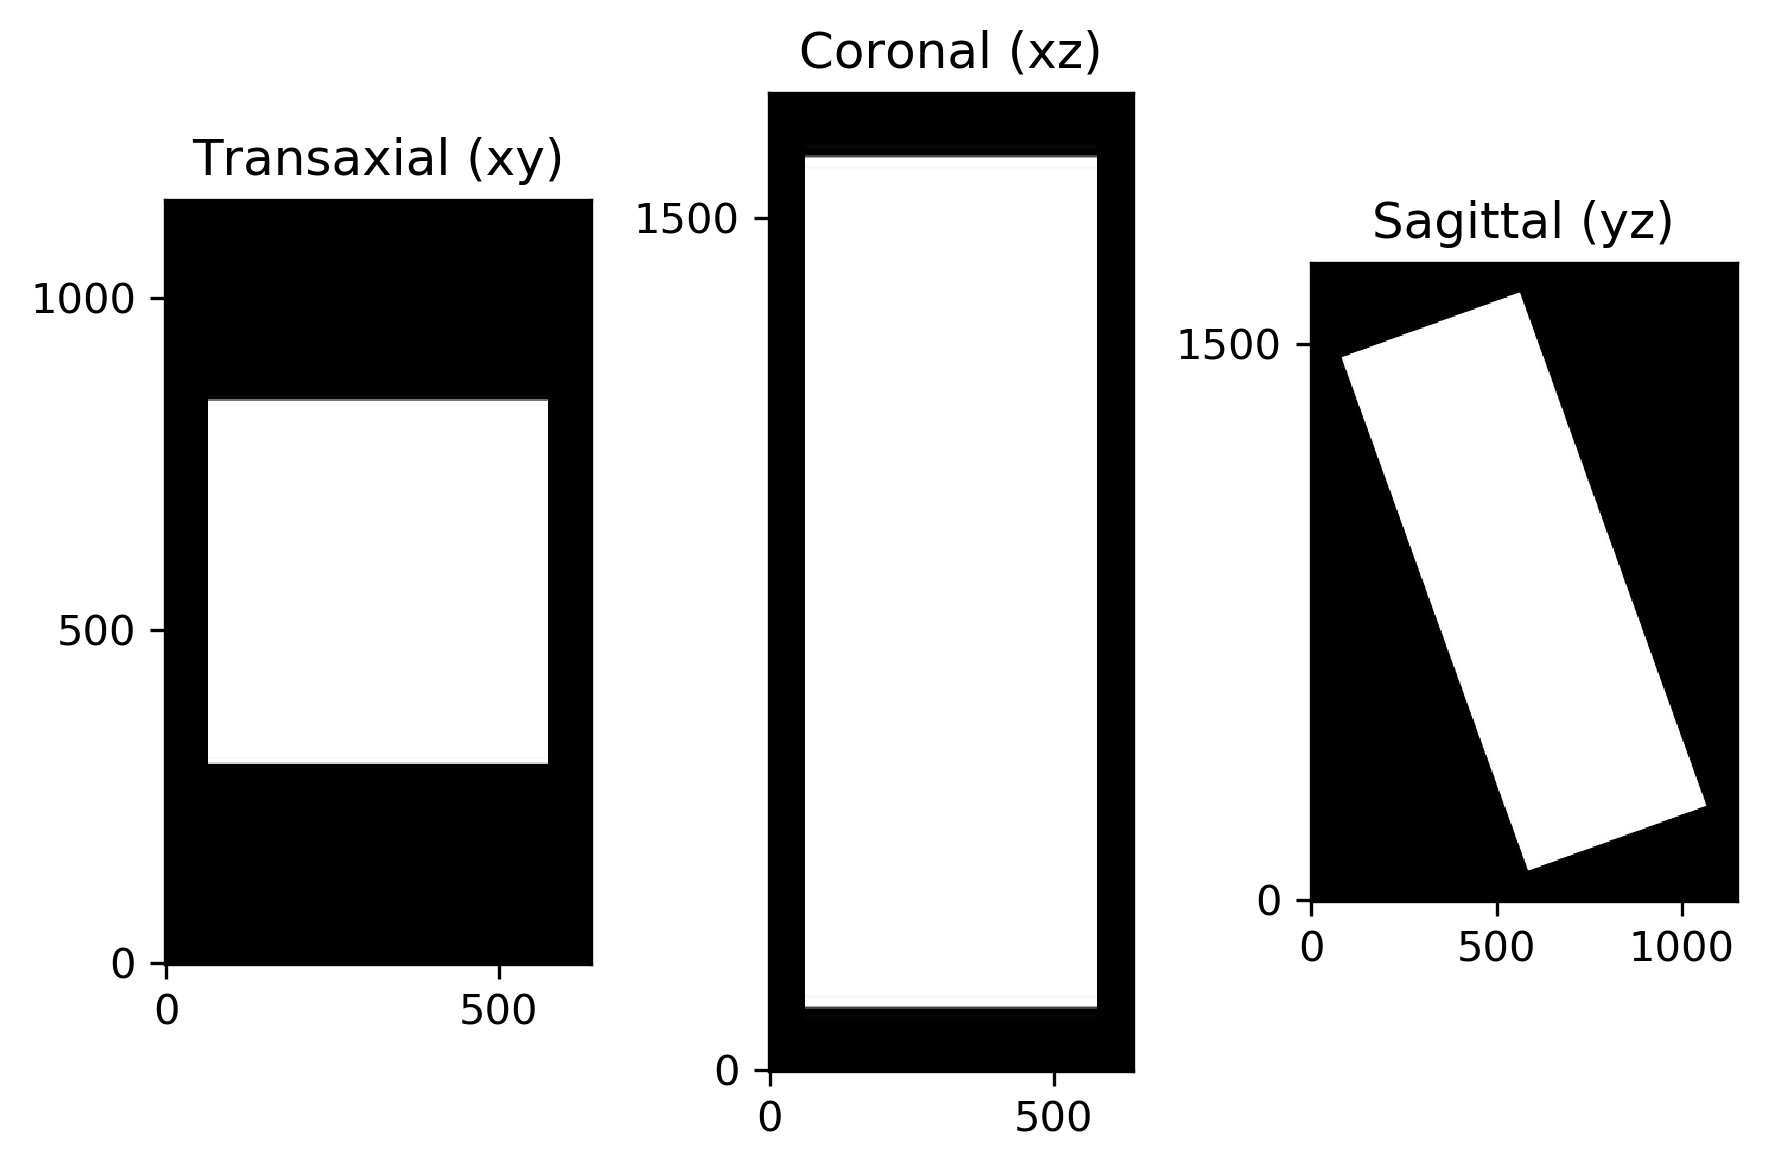

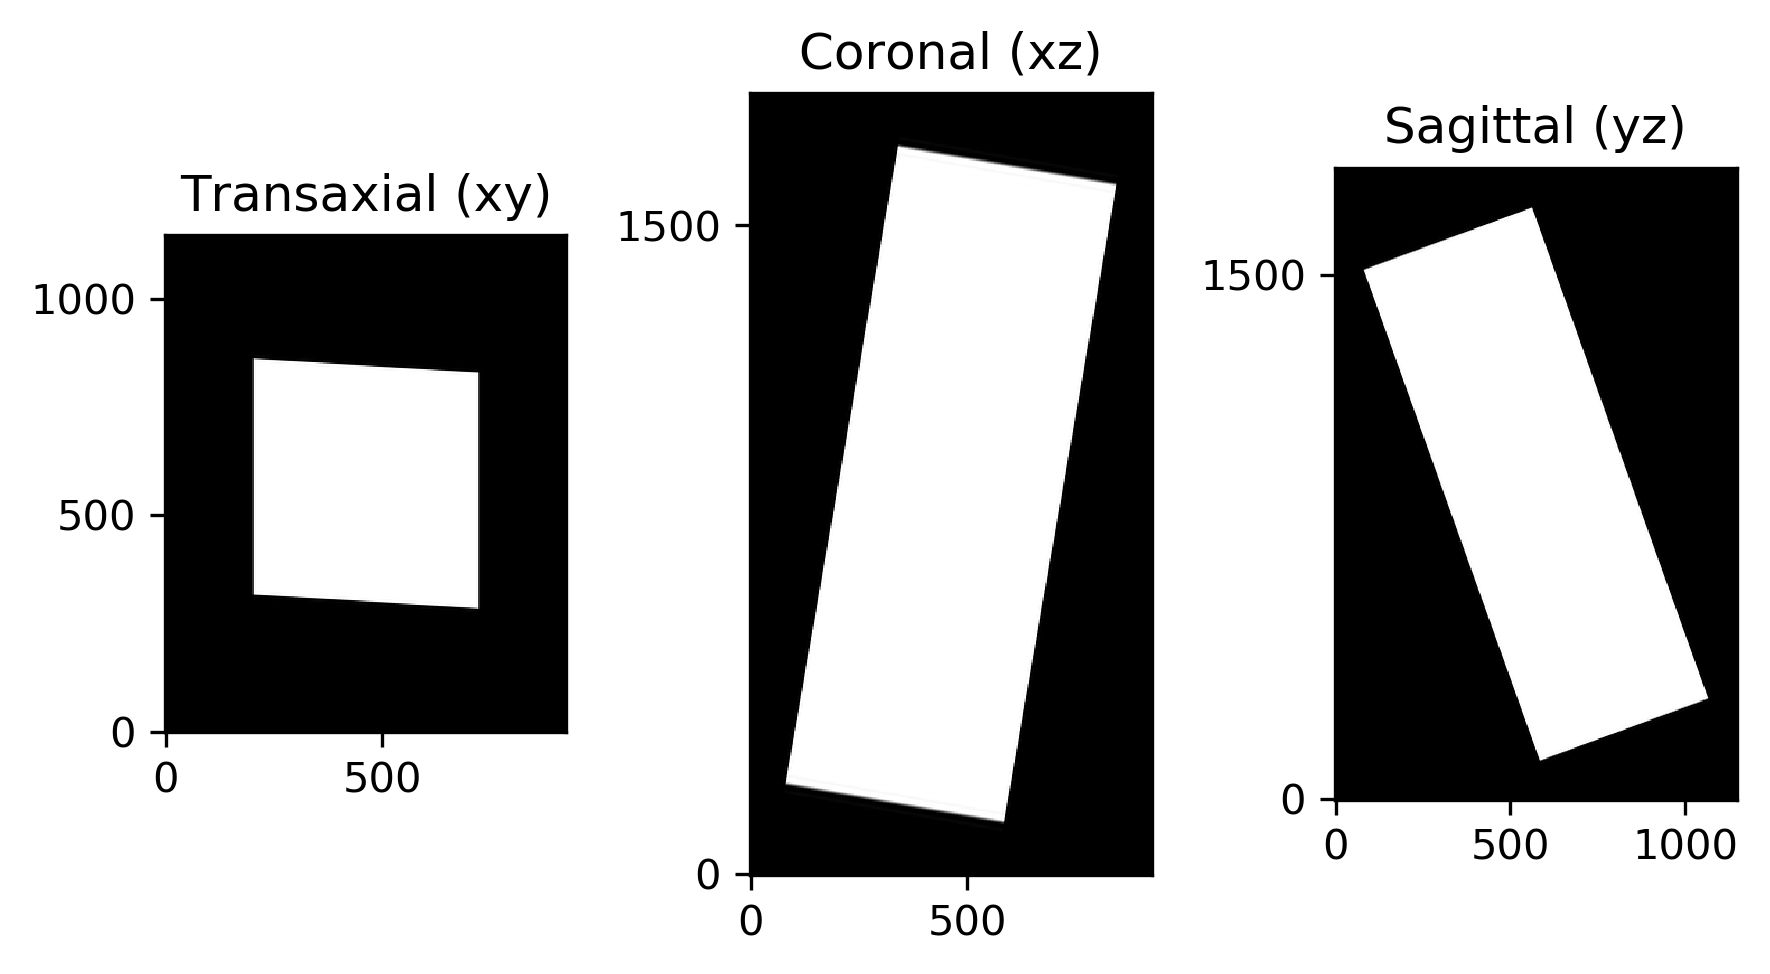

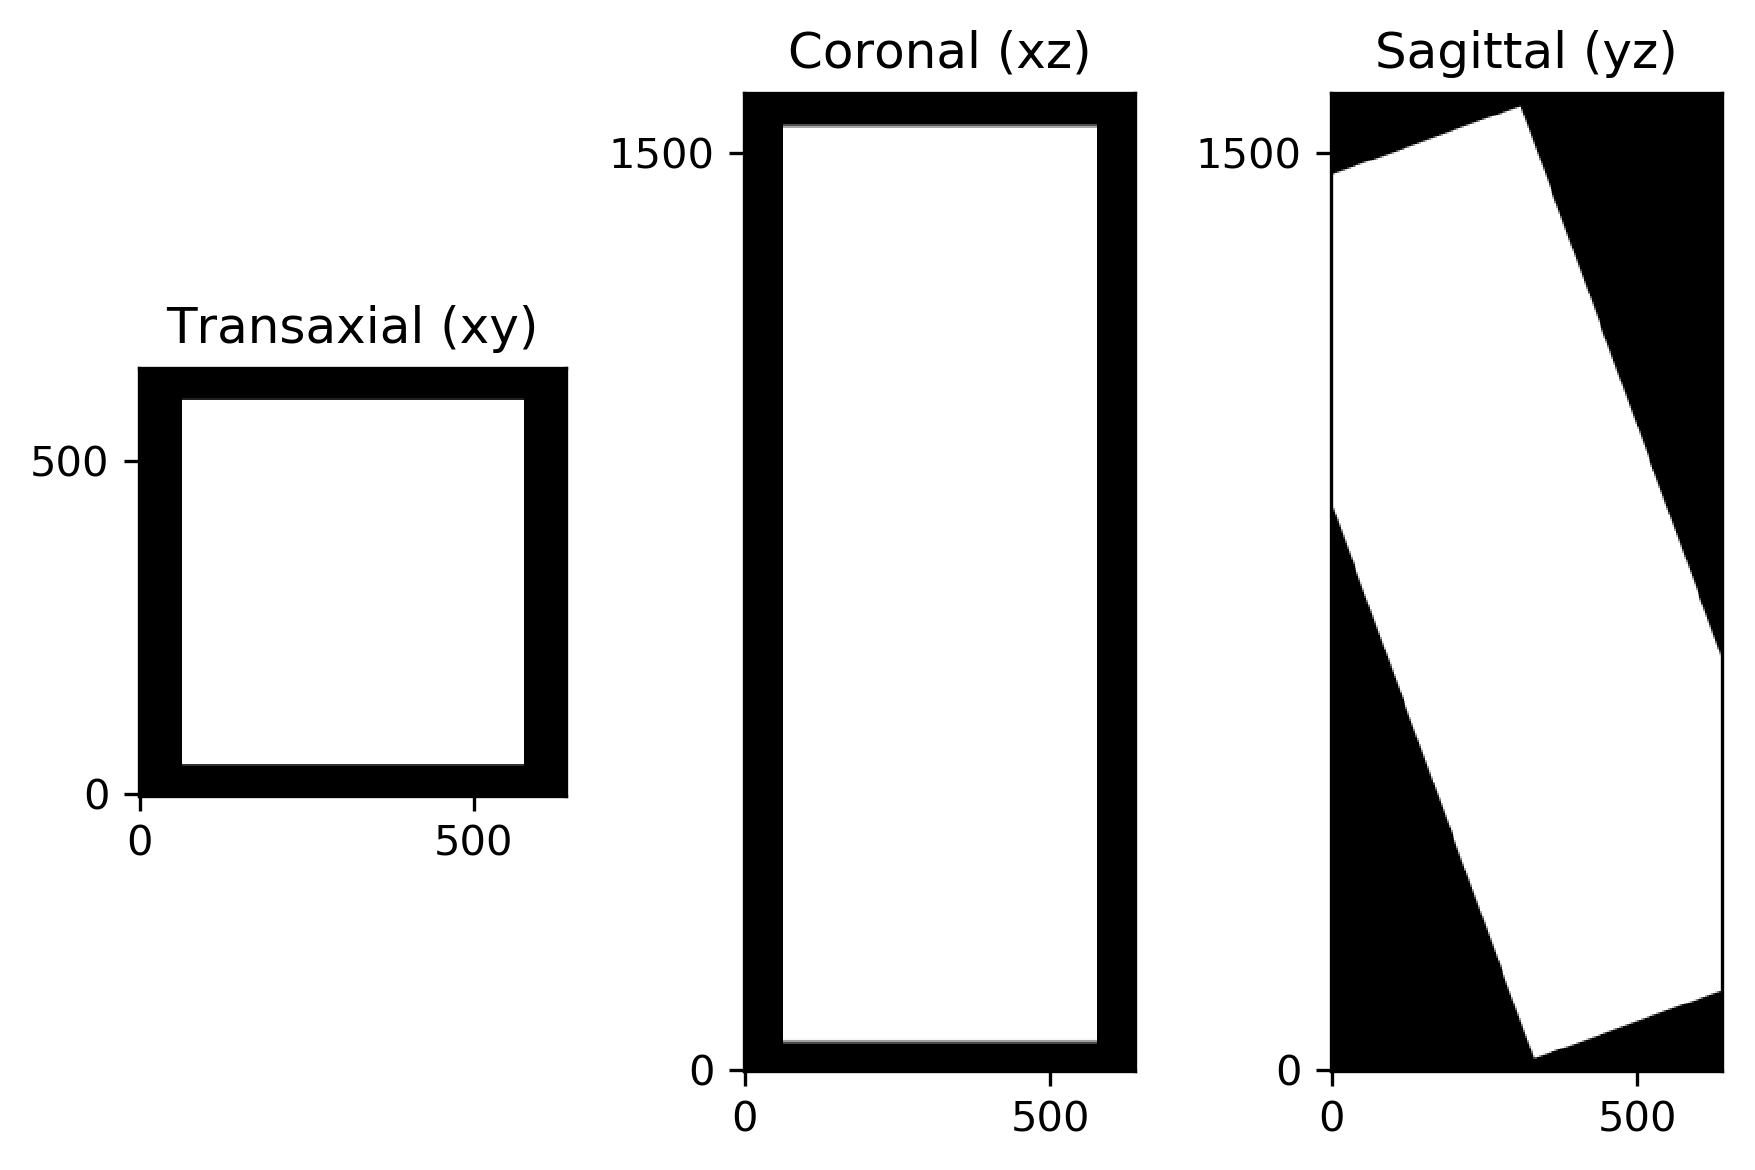

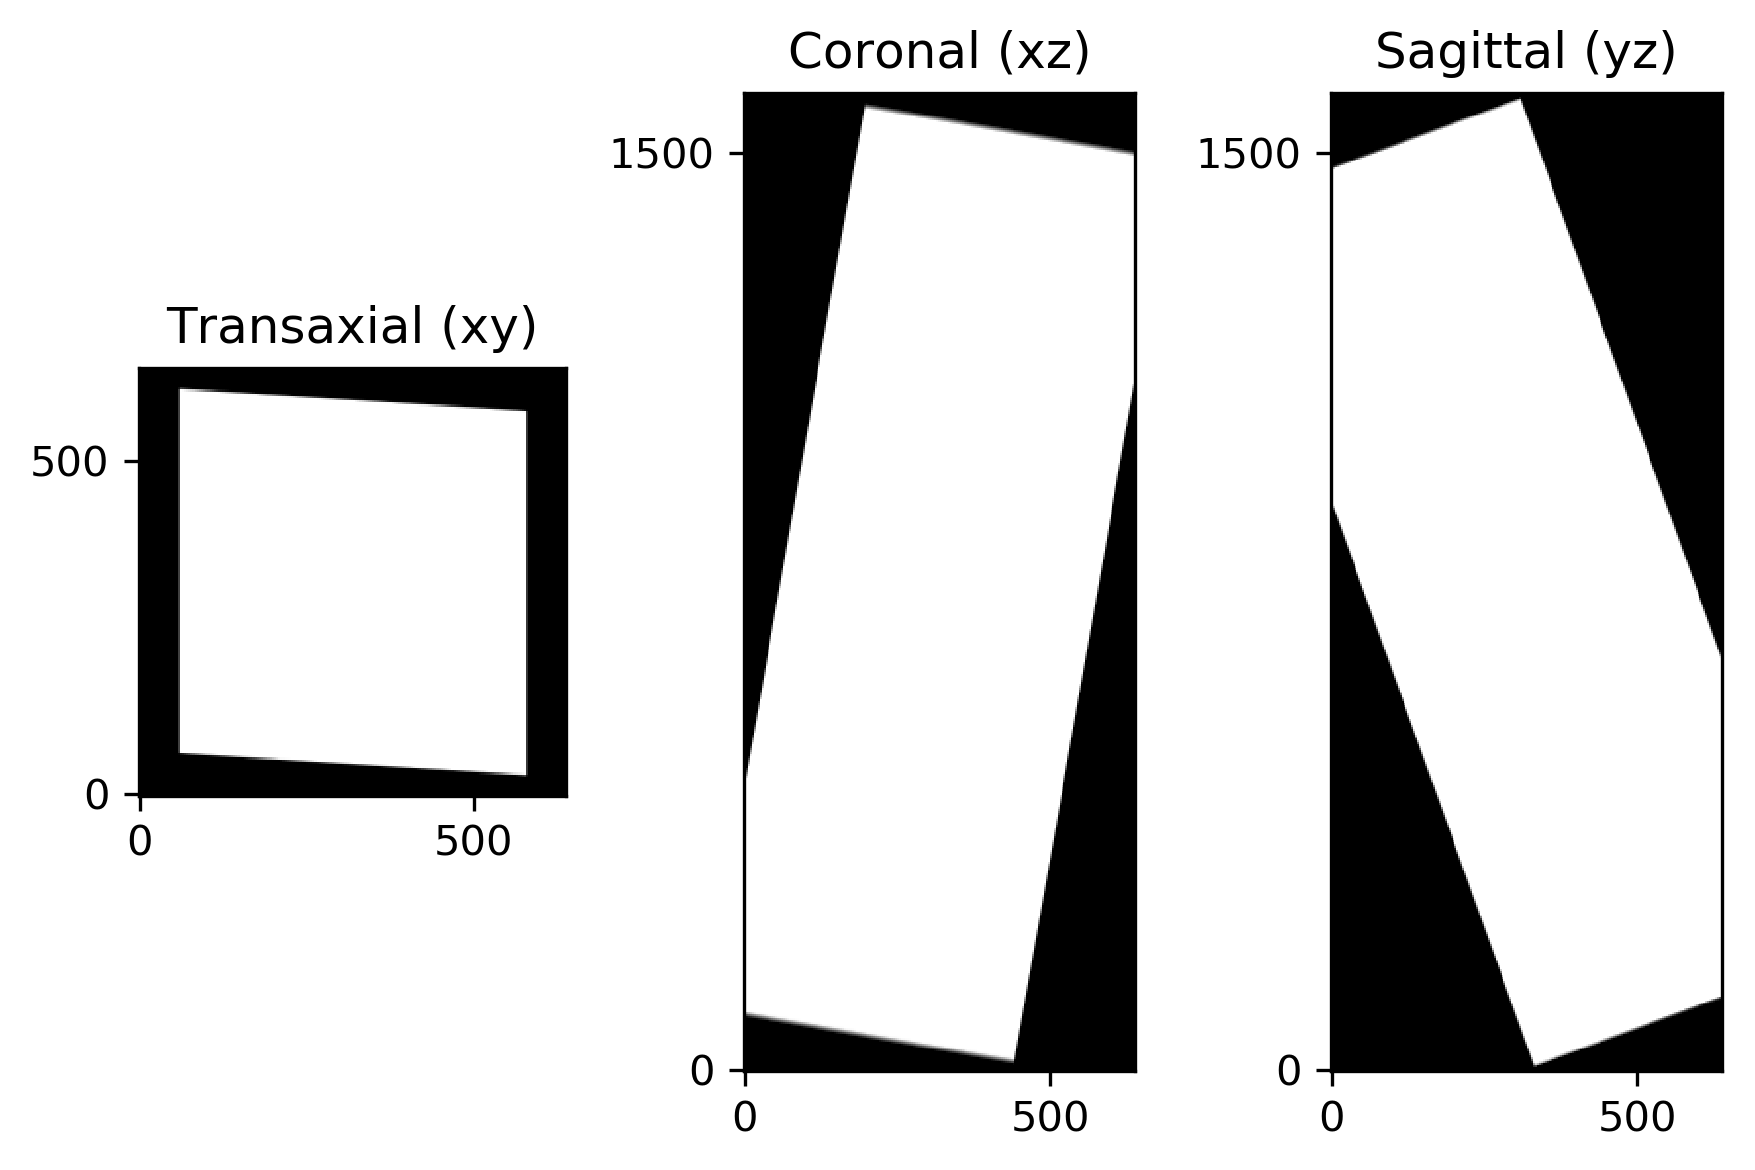

In [4]:
savepath = r'Z:\3DHistoData\Test data\Cube2'
test = np.uint8(np.zeros((200,200,500)))
test[20:-20,20:-20,20:-20] = 255
PrintOrthogonal(test)
test2 = test

#RenderVolume(test)
test = rotate(test, 20, (1,2))
PrintOrthogonal(test)
test = rotate(test, -10, (0,2))
PrintOrthogonal(test)

test2 = opencvRotate(test2, 0, 20)
PrintOrthogonal(test2)
test2 = opencvRotate(test2, 1, -10)
PrintOrthogonal(test2)

#xangle = RotationMatrix(np.pi/4, 0)
#yangle = RotationMatrix(-np.pi/4, 1)
#test = affine_transform(test, xangle)
#test = affine_transform(test, yangle)

#Save(savepath, 'Rotated_Cube', test)
#RenderVolume(test)

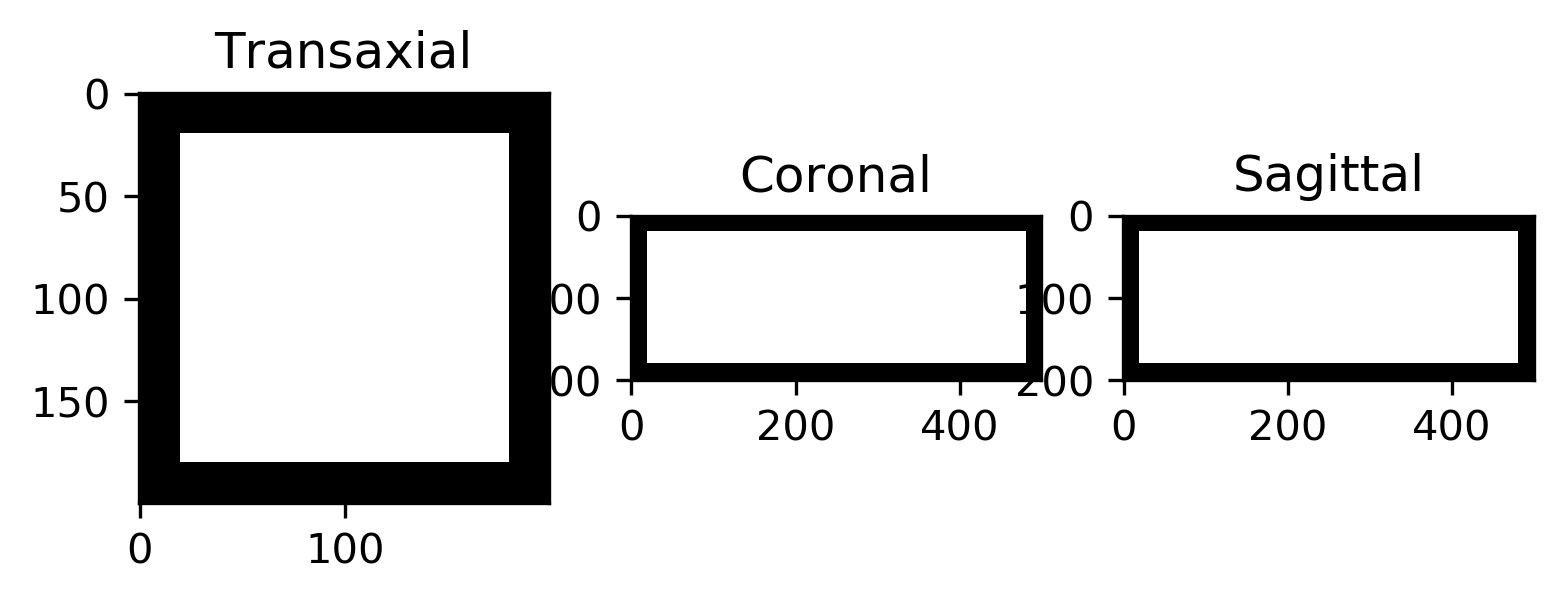

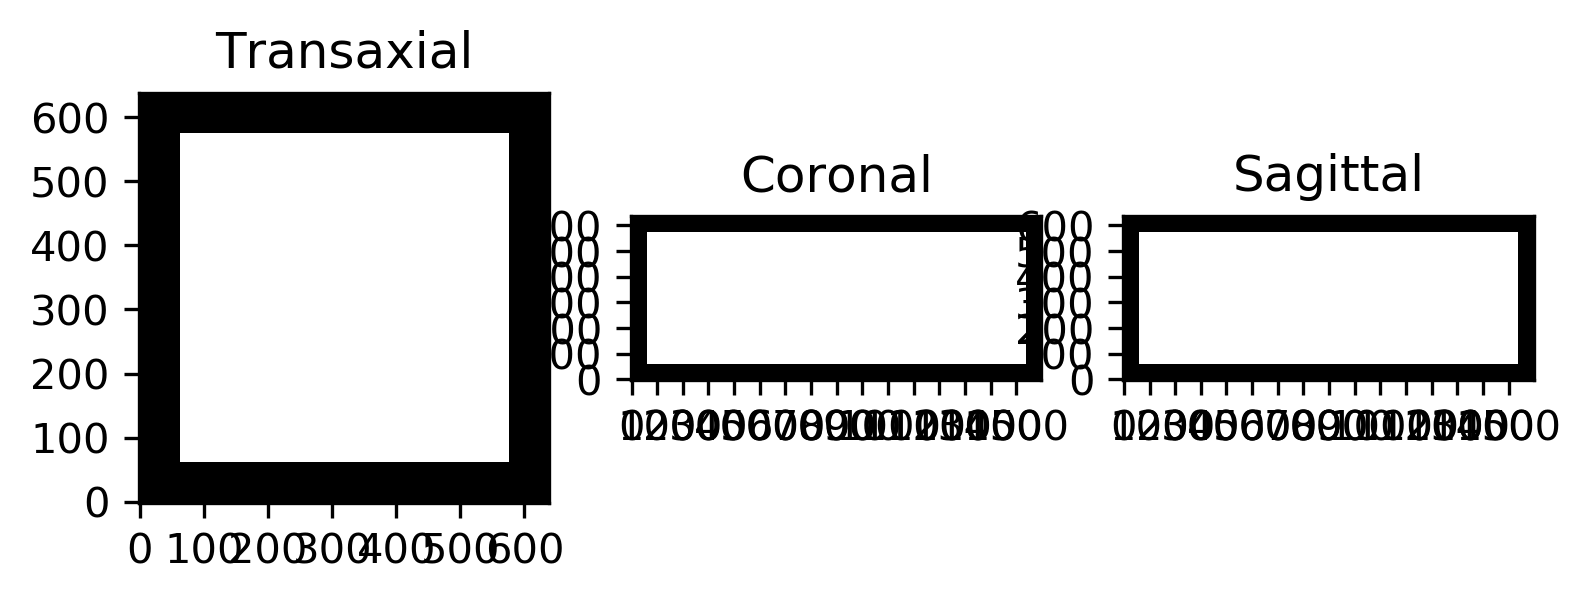

In [33]:
import matplotlib.ticker as ticker
data = test2
dims2 = np.array(np.shape(data))
dims = np.array(np.shape(data)) // 2
x = np.linspace(0, dims[0], dims[0])
y = np.linspace(0, dims[1], dims[1])
z = np.linspace(0, dims[2], dims[2])
scale = 1/3.2
xticks = np.arange(0, dims2[0], 100*scale)
yticks = np.arange(0, dims2[1], 100*scale)
zticks = np.arange(0, dims2[2], 100*scale)

fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(131)
ax1.imshow(data[:,:,dims[2]], cmap='gray')
plt.title('Transaxial')
ax2 = fig.add_subplot(132)
ax2.imshow(data[:,dims[1],:], cmap='gray')
plt.title('Coronal')
ax3 = fig.add_subplot(133)
ax3.imshow(data[dims[0],:,:], cmap='gray')
plt.title('Sagittal')
plt.show()

fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(131)
ax1.imshow(data[:,:,dims[2]], cmap='gray')

plt.title('Transaxial')
ax2 = fig.add_subplot(132)
ax2.imshow(data[:,dims[1],:], cmap='gray')
plt.title('Coronal')
ax3 = fig.add_subplot(133)
ax3.imshow(data[dims[0],:,:], cmap='gray')
plt.title('Sagittal')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale))
ticks_z = ticker.FuncFormatter(lambda z, pos: '{0:g}'.format(z/scale))
ax1.xaxis.set_major_formatter(ticks_x)
ax1.yaxis.set_major_formatter(ticks_y)
ax2.xaxis.set_major_formatter(ticks_x)
ax2.yaxis.set_major_formatter(ticks_z)
ax3.xaxis.set_major_formatter(ticks_y)
ax3.yaxis.set_major_formatter(ticks_z)
ax1.set_xticks(yticks)     
ax1.set_yticks(xticks)
ax2.set_xticks(zticks)
ax2.set_yticks(xticks)
ax3.set_xticks(zticks)     
ax3.set_yticks(yticks)
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

plt.show()

### VTK rendering example

FloatProgress(value=0.0, description='Loading:', max=1876.0)

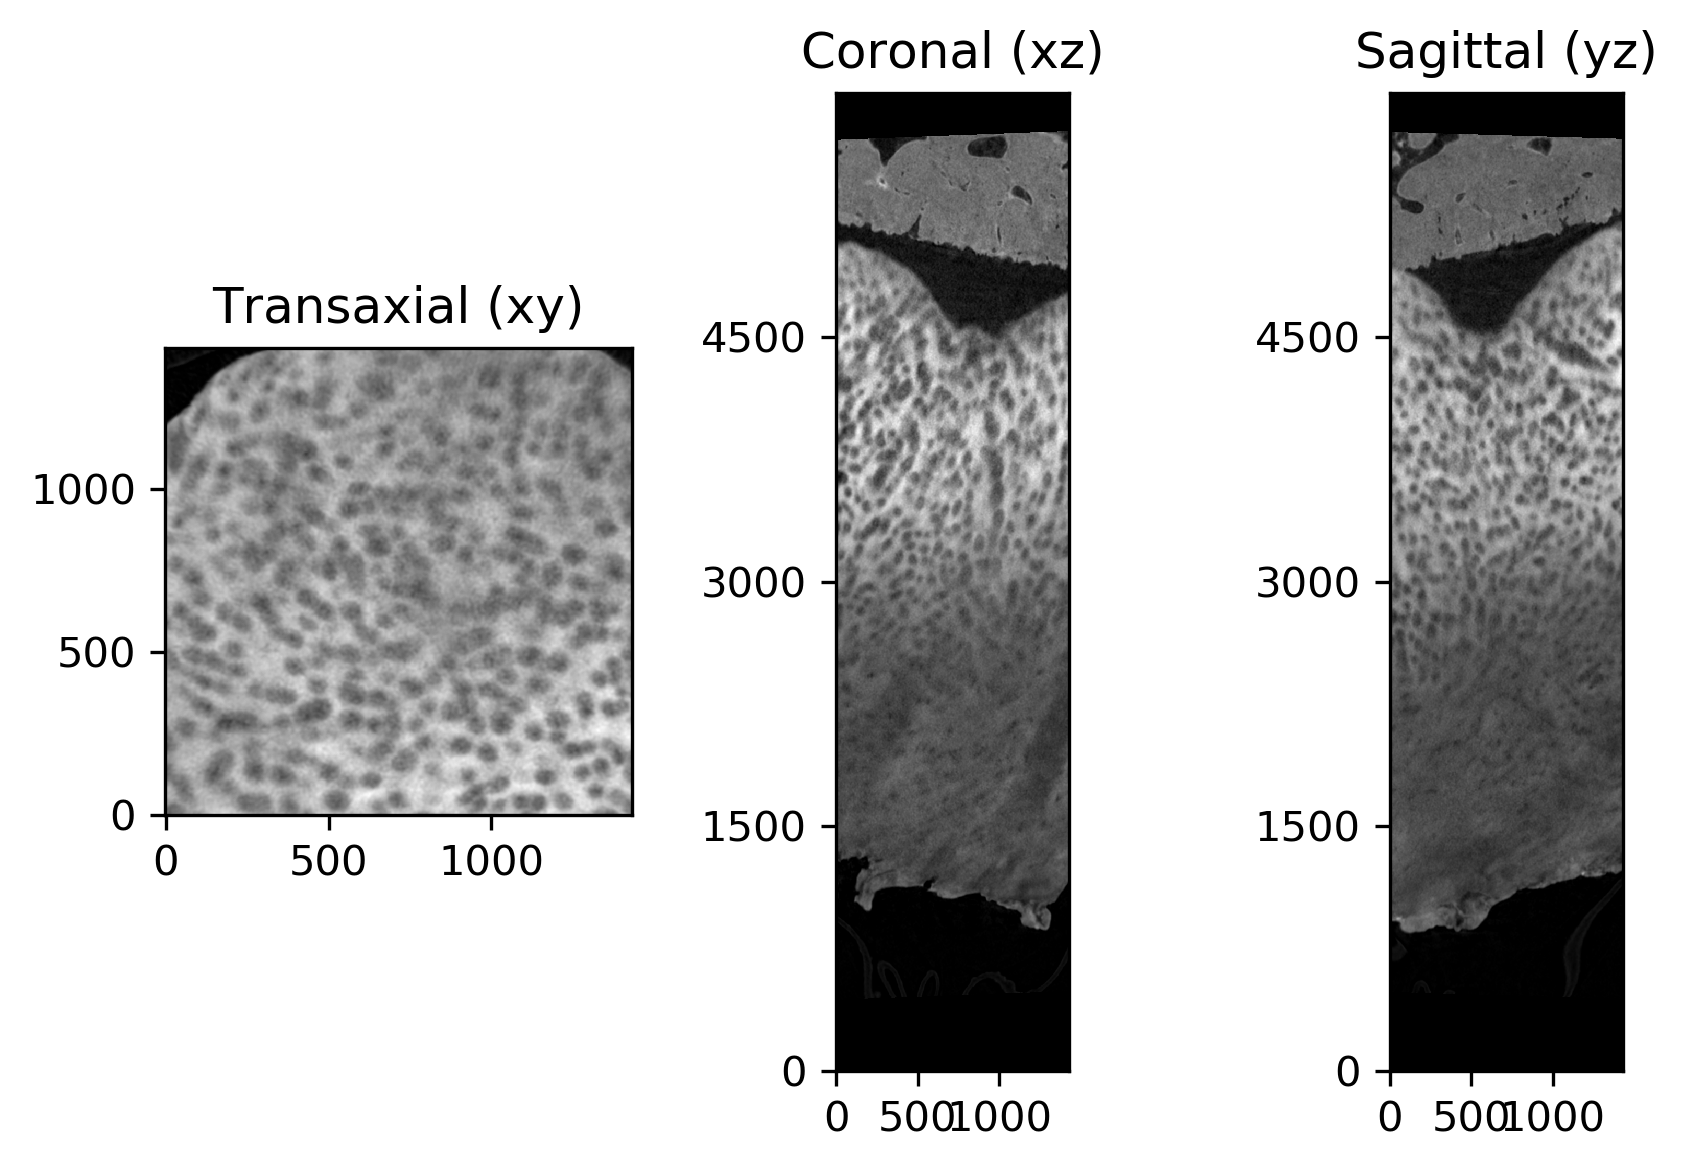

In [2]:
import vtk
from utilities import *
from VTKFunctions import *
# Load and render
path = r"Z:\3DHistoData\Test data\21_L3L_binned"
path = r"Z:\3DHistoData\Test data\Void"
mask = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned\bonemask"
data, bounds = Load(path)
PrintOrthogonal(data)
RenderVolume(data)

### VTK processing

In [ ]:
# Rotate VTK
array = data[:,:,:]
shape = np.shape(array)
vtkdata = ArrayToVTK(array)
Render(vtkdata)
vtkdata = RotateVTK(vtkdata, [90,0,0])
array2 = VTKToArray(vtkdata, shape)
PrintOrthogonal(array)
PrintOrthogonal(array2 - array)

### H5PY saving example

In [ ]:
# Save to h5
savepath = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Saved"
h5 = h5py.File('filename.h5','w')
h5.create_dataset('mean',data=mean)
h5.create_dataset('std',data=std)
h5.close()

h5 = h5py.File('filename.h5','r')
mean = h5['mean'][:]
h5.close()